# Fraud Prediction

## Descrition of columns

* ### step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
​
* ### type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
​
* ### amount - amount of the transaction in local currency.
​
* ### nameOrig - customer who started the transaction
​
* ### oldbalanceOrg - initial balance before the transaction 
​
* ### newbalanceOrig - new balance after the transaction
​
* ### nameDest - customer who is the recipient of the transaction
​
* ### oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).
​
* ### newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).
​
* ### isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
​
* ### isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

# 1.0 Data Description 

In [1]:
# Importing libraries
import numpy as np 
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm_notebook
import seaborn as sns
%matplotlib inline 

from category_encoders import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [2]:
 # Loading dataset

df = pd.read_csv('Fraud.csv')

In [3]:
# Showing the first dataset data

df.head(8)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.0,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.0,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.0,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.0,0,0


In [4]:
# Showing features types 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


* ## The total features in the dataset are represented by 11 columns: 3 columns containing object type data 
## and the others containing numeric type data.

# 2.0 Data filtering

In [5]:
# checking for missing data in columns

df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

 * ## No missing data in columns.

In [6]:
### Analyzing column with names of customers who start the transaction and 
### column names of customers who are recipients of the transaction.abs.

df['nameOrig'].value_counts()

C1065307291    3
C400299098     3
C1530544995    3
C724452879     3
C2051359467    3
              ..
C291446134     1
C700339190     1
C113082250     1
C341325843     1
C365459535     1
Name: nameOrig, Length: 6353307, dtype: int64

In [7]:
df['nameDest'].value_counts()

C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
              ... 
C720935305       1
M156793230       1
M209822240       1
C1462629483      1
M1925027612      1
Name: nameDest, Length: 2722362, dtype: int64

 * ## The customer names in the 'nameOrig' and 'nameDest' columns are repeated very infrequently, so we can exclude them from our model.

# 3.0 Exploratory Data Analysis

## 3.1 Showing the outliers in the dataset

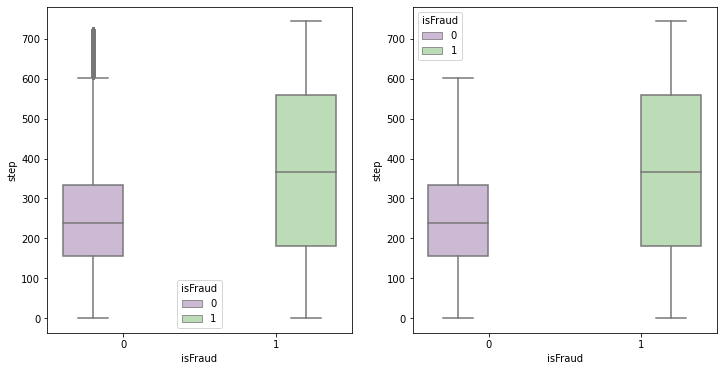

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="isFraud", y="step", hue="isFraud",data=df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="isFraud", y="step", hue="isFraud",data=df, palette="PRGn",showfliers=False)
plt.show()

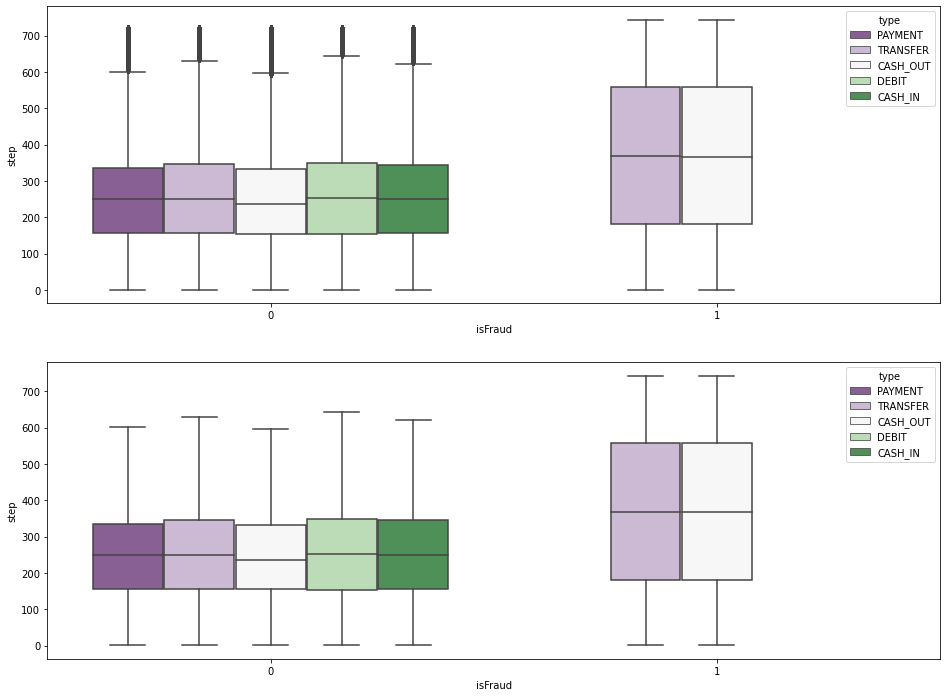

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16,12))
s = sns.boxplot(ax = ax1, x="isFraud", y="step", hue="type",data=df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="isFraud", y="step", hue="type",data=df, palette="PRGn",showfliers=False)
plt.show()

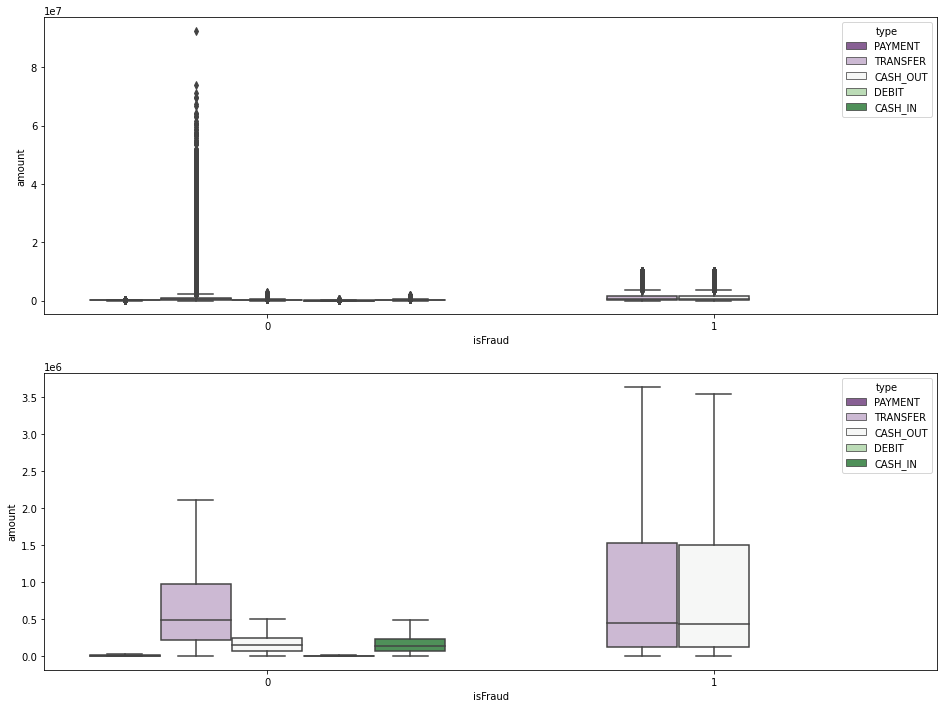

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16,12))
s = sns.boxplot(ax = ax1, x="isFraud", y="amount", hue="type",data=df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="isFraud", y="amount", hue="type",data=df, palette="PRGn",showfliers=False)
plt.show()

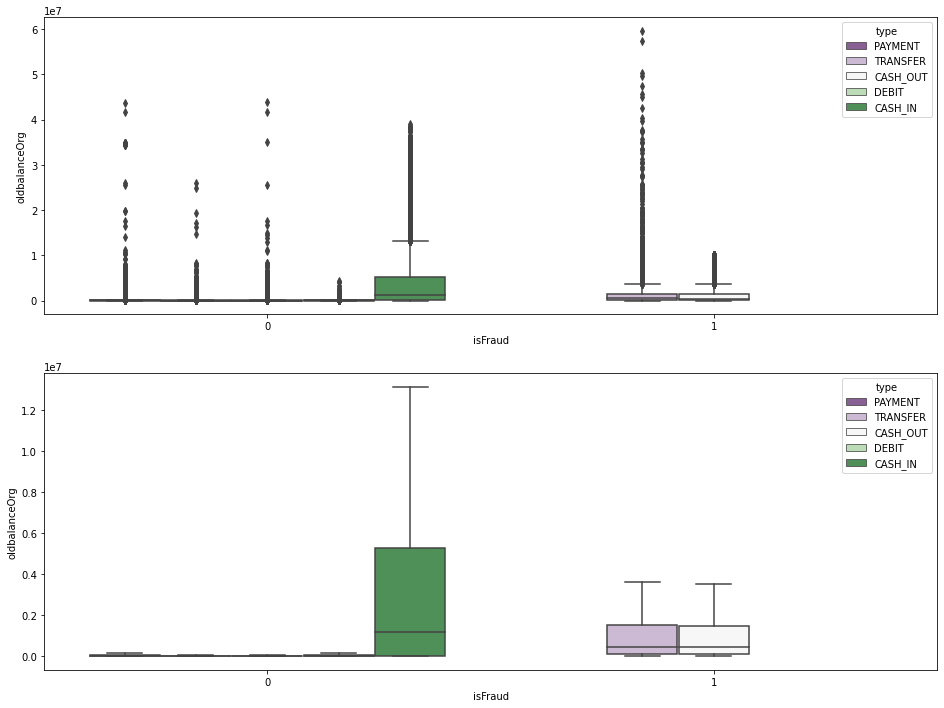

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16,12))
s = sns.boxplot(ax = ax1, x="isFraud", y="oldbalanceOrg", hue="type",data=df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="isFraud", y="oldbalanceOrg", hue="type",data=df, palette="PRGn",showfliers=False)
plt.show()

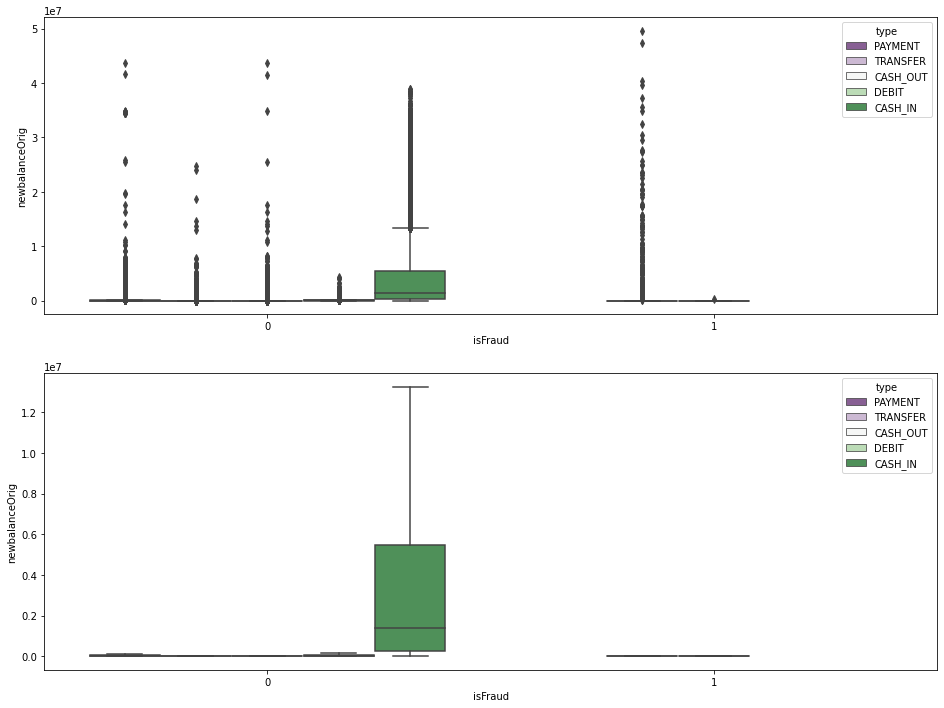

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16,12))
s = sns.boxplot(ax = ax1, x="isFraud", y="newbalanceOrig", hue="type",data=df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="isFraud", y="newbalanceOrig", hue="type",data=df, palette="PRGn",showfliers=False)
plt.show()

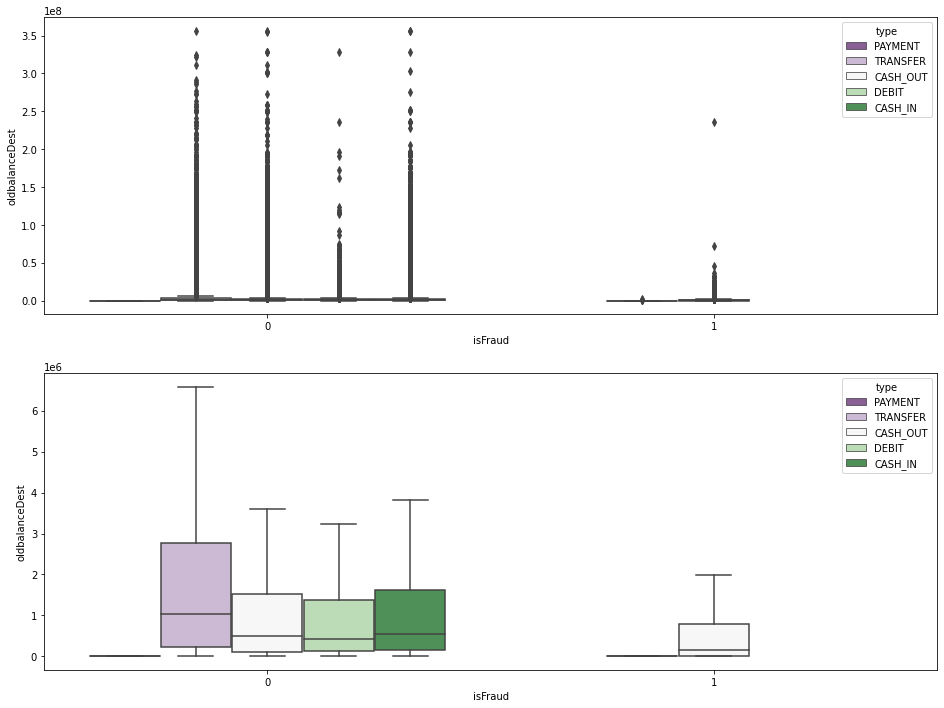

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16,12))
s = sns.boxplot(ax = ax1, x="isFraud", y="oldbalanceDest", hue="type",data=df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="isFraud", y="oldbalanceDest", hue="type",data=df, palette="PRGn",showfliers=False)
plt.show()

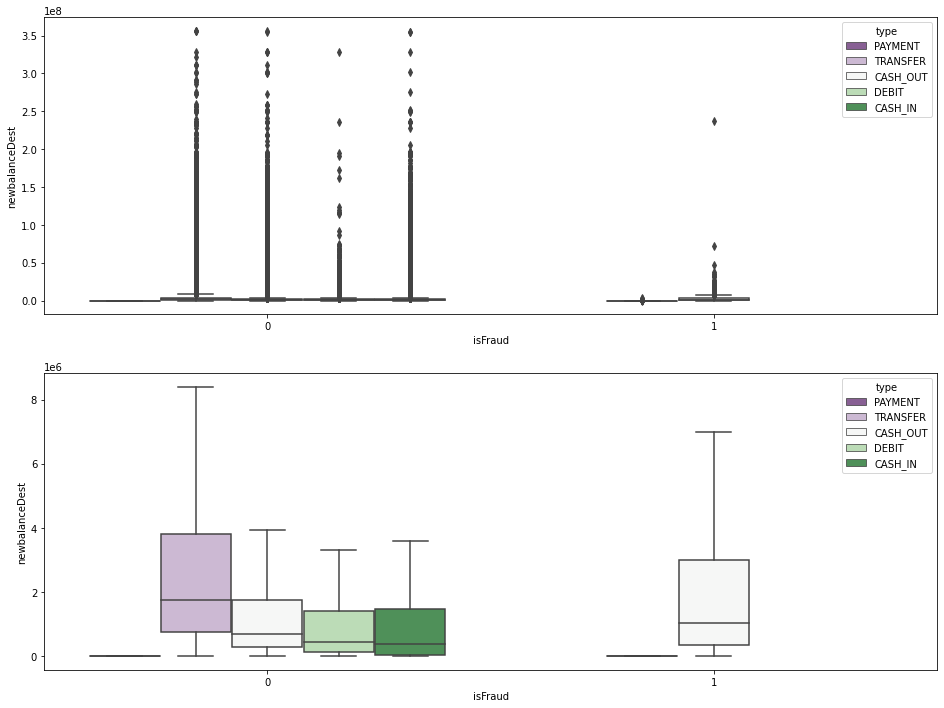

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16,12))
s = sns.boxplot(ax = ax1, x="isFraud", y="newbalanceDest", hue="type",data=df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="isFraud", y="newbalanceDest", hue="type",data=df, palette="PRGn",showfliers=False)
plt.show()

* ## The columns 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', and 'newbalanceDest' show many outliers values. Let's see if outliers don't interfere with the performance of our forecasting model.

 ## 3.2 Hypothesis testing on fraud data

## Hypothesis one: Fraudulent transaction events are much less often than non-fraudulent events.

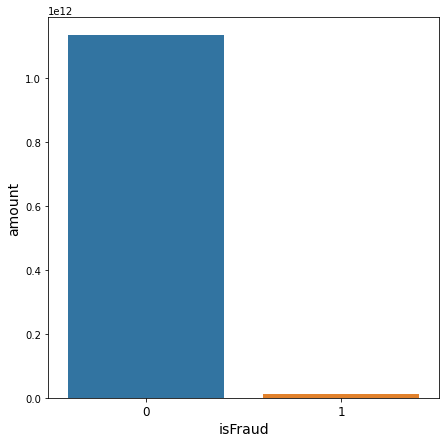

In [15]:
# Sum amount values in terms  fraud and no-fraud
data = df[['isFraud', 'amount']].groupby(['isFraud'], as_index=False).sum().sort_values(by='amount',ascending=False).head(n=2)
plt.figure(figsize = (7, 7))
plt.xlabel('isFlaggedFraud', size = 14)
plt.ylabel('amount', size = 14)
plt.xticks(size=12)
sns.barplot(x='isFraud', y= 'amount', data=data);

0    6354407
1       8213
Name: isFraud, dtype: int64


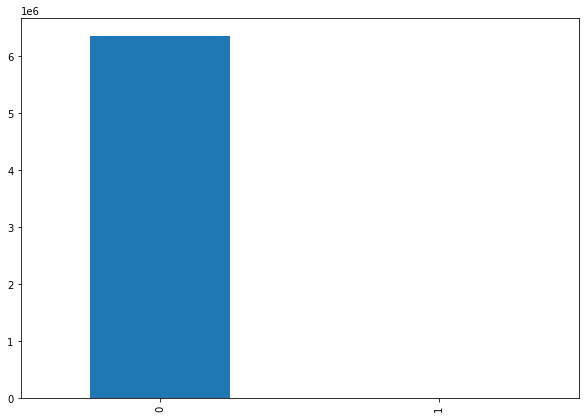

In [16]:
# Count values in terms  fraud and no-fraud
print(df['isFraud'].value_counts())

plt.figure(figsize = (10, 7))
df['isFraud'].value_counts().plot(kind= 'bar')
plt.show()

<AxesSubplot:>

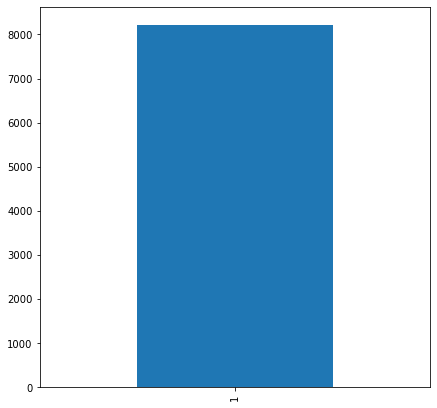

In [17]:
# Showing fraud event count only
plt.figure(figsize = (7, 7))
df['isFraud'][df['isFraud']==1].value_counts().plot(kind = 'bar')

* ## Hypothesis one conclusion: The hypothesis is confirmed 

 ## Hypothesis two: Fraudulent transaction events have an average amount monetary greater than  average non-fraudulent events.

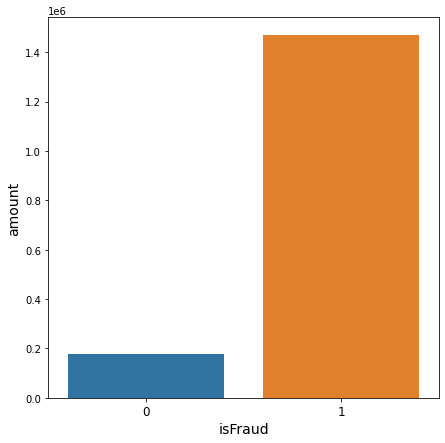

In [18]:
# Grouping mean amount values by fraud or no-fraud events
data2 = df[['isFraud', 'amount']].groupby(['isFraud'], as_index=False).mean().sort_values(by='amount',ascending=False).head(n=2)

plt.figure(figsize = (7, 7))
plt.xlabel('isFraud', size = 14)
plt.ylabel('amount', size = 14)
plt.xticks(size=12)
sns.barplot(x='isFraud', y= 'amount', data=data2);

* ## Hypothesis two conclusion: The hypothesis is confirmed, the mean amount to fraudulent is events lot greater then no-fraudulent events.

## Hypothesis three: The average of the time values ​​that occur between transactions, 'step', for fraudulent events must be less than the observed average for non-fraudulent events.

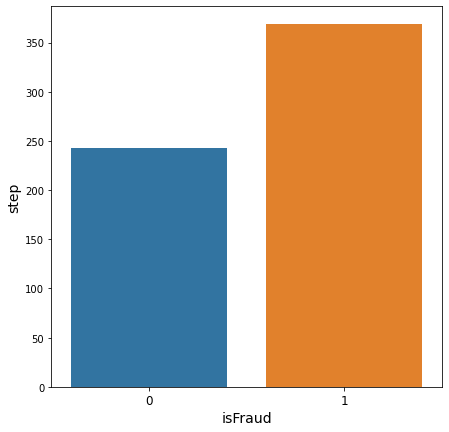

In [19]:
data4 = df[['isFraud', 'step']].groupby(['isFraud'], as_index=False).mean().sort_values(by='step',ascending=False).head(n=2)
plt.figure(figsize = (7, 7))
plt.xlabel('isFraud', size = 14)
plt.ylabel('step', size = 14)
plt.xticks(size=12)
sns.barplot(x='isFraud', y= 'step', data=data4);

* ## Hypothesis three conclusion: The hypothesis no confirmed, the average of the time values ​​that occur between transactions for fraudulent events is greater than the average observed for non-fraudulent events.

 ## Hypothesis four: The mean value of 'oldbalanceOrg' is greater for fradulent events than the mean of 'oldbalanceOrg' for non-fraudulent events.

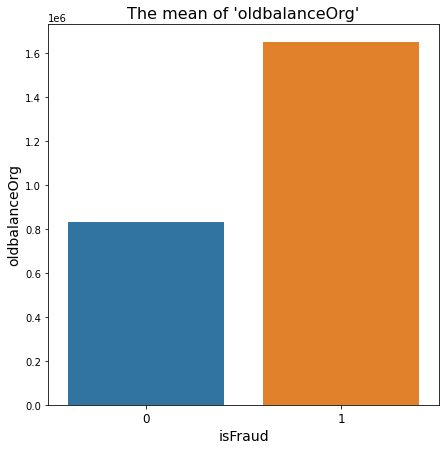

In [20]:
# Average value of 'oldbalanceOrg' values ​​grouped by fraud events.
data5 = df[['isFraud', 'oldbalanceOrg']].groupby(['isFraud'], as_index=False).mean().sort_values(by='oldbalanceOrg',ascending=False).head(n=2)
plt.figure(figsize = (7, 7))
plt.xlabel('isFraud', size = 14)
plt.ylabel('oldbalanceOrg', size = 14)
plt.xticks(size=12)
plt.title("The mean of 'oldbalanceOrg'", size=16)
sns.barplot(x='isFraud', y= 'oldbalanceOrg', data=data5);

* ## Hypothesis four conclusion: The hypothesis is confirmad.

 ## Hypothesis five: The mean value of 'newbalanceOrg' is greater for fradulent events than the mean of 'newbalanceOrg' for non-fraudulent events.

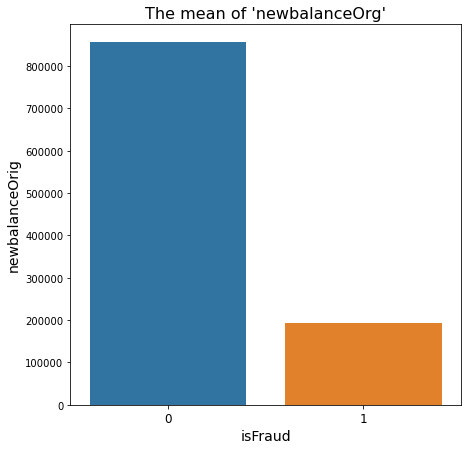

In [21]:
# Average value of 'newbalanceOrg' values ​​grouped by fraud events.
data6 = df[['isFraud', 'newbalanceOrig']].groupby(['isFraud'], as_index=False).mean().sort_values(by='newbalanceOrig',ascending=False).head(n=2)
plt.figure(figsize = (7, 7))
plt.xlabel('isFraud', size = 14)
plt.ylabel('newbalanceOrig', size = 14)
plt.title("The mean of 'newbalanceOrg'", size=16)
plt.xticks(size=12)
sns.barplot(x='isFraud', y= 'newbalanceOrig', data=data6);

* ## Hypothesis five conclusion: The hypothesis five is no confirmed, the 'newbalanceOrig' average for fraudulent events is less than the 'newbalanceOrig' average for non-fraudulent events.

 ## Hypothesis six: The mean value of 'oldbalanceDest' is smaller for fradulent events than the mean of 'oldbalanceDest' for non-fraudulent events.

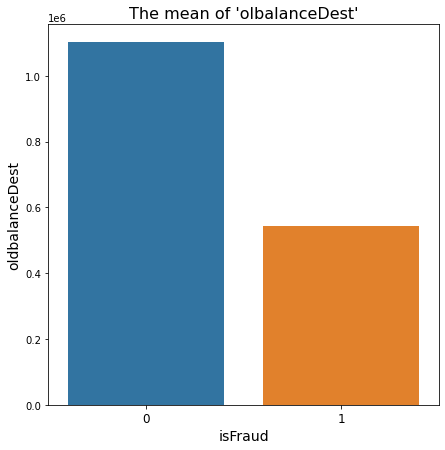

In [22]:
# Average value of 'oldbalanceDest' values ​​grouped by fraud events.
data7 = df[['isFraud', 'oldbalanceDest']].groupby(['isFraud'], as_index=False).mean().sort_values(by='oldbalanceDest',ascending=False).head(n=2)
plt.figure(figsize = (7, 7))
plt.xlabel('isFraud', size = 14)
plt.ylabel('oldbalanceDest', size = 14)
plt.title("The mean of 'olbalanceDest'", size=16)
plt.xticks(size=12)
sns.barplot(x='isFraud', y= 'oldbalanceDest', data=data7);

* ## Hypothesis six conclusion: The hypothesis is confirmed.

## Hypothesis seven: The mean value of 'newbalanceDest' is smaller for fradulent events than the mean of 'newbalanceDest' for non-fraudulent events.

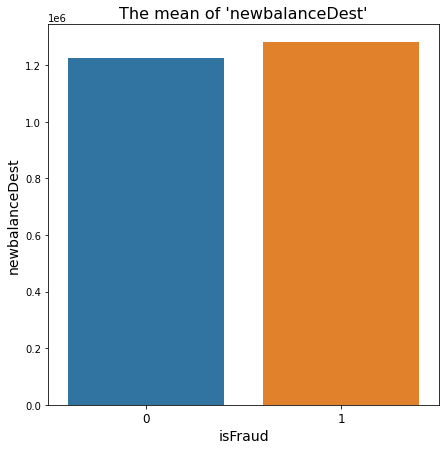

In [23]:
data8 = df[['isFraud', 'newbalanceDest']].groupby(['isFraud'], as_index=False).mean().sort_values(by='newbalanceDest',ascending=False).head(n=2)
plt.figure(figsize = (7, 7))
plt.xlabel('isFraud', size = 14)
plt.ylabel('newbalanceDest', size = 14)
plt.title("The mean of 'newbalanceDest'", size=16)
plt.xticks(size=12)
sns.barplot(x='isFraud', y= 'newbalanceDest', data=data8);

* ## Hypothesis seven conslusion: The hypothesis is not confimad, but we should note that the two classes of fraud are almost equivalent.

## Hypothesis eight: All types of payment must take place in the event of fraudulent transactions.

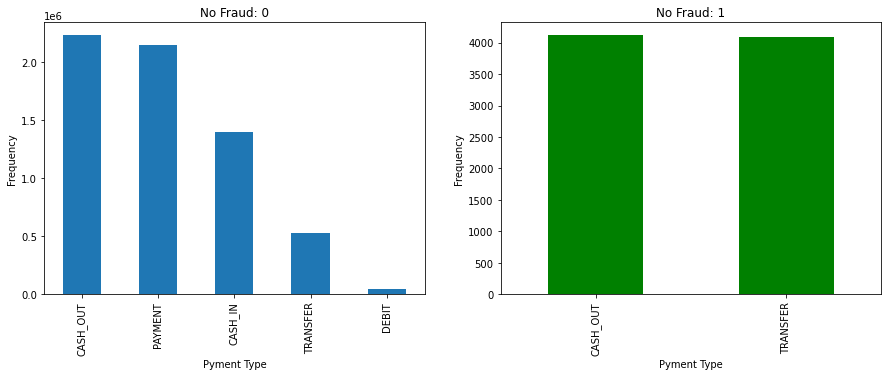

In [24]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
ex1= df['type'][df['isFraud']==0].value_counts().plot(kind='bar')
plt.title('No Fraud: 0')
ex1.set(xlabel = 'Pyment Type', ylabel='Frequency')

plt.subplot(1,2,2)
ex1= df['type'][df['isFraud']==1].value_counts().plot(kind='bar', color = 'g')
plt.title('No Fraud: 1')
ex1.set(xlabel = 'Pyment Type', ylabel='Frequency')

plt.show()

* ## Hypothesis eight conslusion: The Hypothesis is no confirmed, the 'CASH_OUT' and 'TRANSFER' are the only forms of payment in fraudulent transaction events.

# 4.0  Data Preparation.

## 4.1 Drop useless columns and split features data e target data.

In [4]:
# How we already saw above, the columns 'nameOrig','nameDest' don´t have influence to forecast model.
df = df.drop(['nameOrig','nameDest'], axis = 1)

In [5]:
# The 'isFlaggedFraud' column is derivad in the 'isFraud' column, then is redudent.
X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df.isFraud

## 4.2 Dealing with unbalanced classes.

### The class representing non-fraud events has 6354407 records, while fraud events have only 8213 records. This is an example of unbalanced classes that could affect significantly the performance of the classification model.

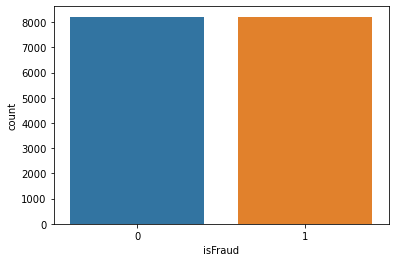

In [6]:
# We used the undersampling technique to get a reduzided sample from the major classe.

nr = NearMiss()

under_sampler = RandomUnderSampler()
X0, y0 = under_sampler.fit_resample(X, y)

np.bincount(y0)

ax = sns.countplot(x=y0)

# 5.0 Feature Selection

## 5.1 Analysing the best data features using the correlation function.

In [ ]:
f, ax = plt.subplots(figsize = (20, 20))
sns.heatmap(df.corr(), annot = True);

# 6.0 Machine Learning Modelling

## 6.1 Training model using CatBoostClassifier.

In [7]:
# Splitting the features data and target data in train and validation parts.
X_train, X_validation, y_train, y_validation = train_test_split(X0, y0, train_size=0.7, random_state=1234)

In [8]:
# Building CatBoostClassifier 
categorical_features_indices = np.where(X0.dtypes != np.float)[0]
clf = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 20,
                             od_wait=25)

In [9]:
# Fitting data  and training the model
clf.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_validation, y_validation),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.9873206	best: 0.9873206 (0)	total: 265ms	remaining: 2m 12s
20:	test: 0.9974868	best: 0.9975156 (18)	total: 7.82s	remaining: 2m 58s
40:	test: 0.9988322	best: 0.9988322 (40)	total: 17.7s	remaining: 3m 18s
60:	test: 0.9989483	best: 0.9989483 (60)	total: 27.2s	remaining: 3m 16s
80:	test: 0.9990142	best: 0.9990142 (80)	total: 37s	remaining: 3m 11s
100:	test: 0.9990523	best: 0.9990566 (93)	total: 46.4s	remaining: 3m 3s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.9990565781
bestIteration = 93

Shrink model to first 94 iterations.


In [10]:
# Creating the prediction values
preds = clf.predict(X_validation)

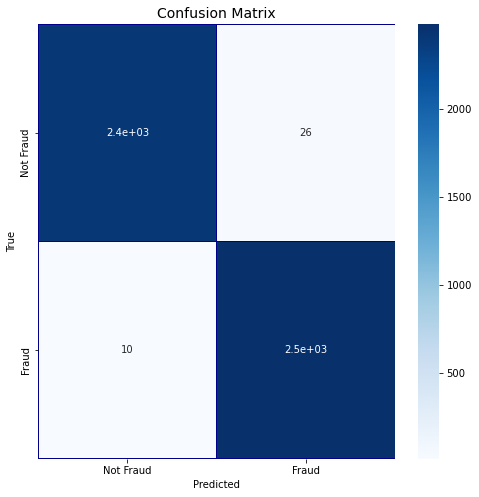

In [11]:
# Creating confusion matrix of true and predicted values
cm = pd.crosstab(y_validation.values, preds, rownames=['True'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(8,8))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [12]:
# Evaluating the ranking model performance metric
print (classification_report(y_validation, preds))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2435
           1       0.99      1.00      0.99      2493

    accuracy                           0.99      4928
   macro avg       0.99      0.99      0.99      4928
weighted avg       0.99      0.99      0.99      4928



## Clearly the CatBoostClassifier model ranks both classes very well.

In [13]:
## The ROC-AUC metric tells us how reliable our forecasting model is.
print(f"ROC-AUC score: {roc_auc_score(y_validation.values, preds)}")

ROC-AUC score: 0.9926555752410652


## The ROC-AUC score show the CatBoostClassifier model proves to be very trustworthy.

## 6.2 Training model using XGBClassifier

In [15]:
# Encoding the categorical feature of data features
ordinal = OrdinalEncoder()
x_train0 = ordinal.fit_transform(X_train)

ordinal = OrdinalEncoder()
x_test0 = ordinal.fit_transform(X_validation)

In [16]:
# Building XGBClassifier model
xgbc = XGBClassifier()

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1) 


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, monotone_constraints=None,
              n_estimators=100, n_jobs=1, nthread=None, num_parallel_tree=None,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, tree_method=None, validate_parameters=None,
              verbosity=1)

In [17]:
# Training the model 
xgbc.fit(x_train0, y_train)

C:\Users\rondi\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:46:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [18]:
# Creating the prediction values

ypred = xgbc.predict(x_test0)

C:\Users\rondi\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


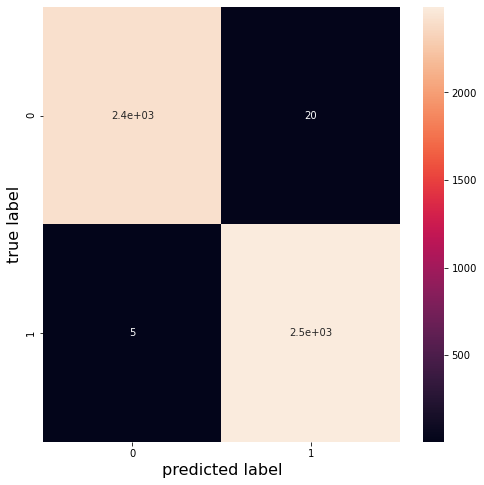

In [19]:
# Creating confusion matrix of true and predicted values
plt.figure(figsize = (8, 8))
ypred = (ypred > 0.5)
cm = confusion_matrix(y_validation, ypred)
sns.heatmap(cm, annot=True)
plt.xlabel("predicted label", fontsize=16)
plt.ylabel("true label", fontsize=16);

In [20]:
# Evaluating the ranking model performance metric
print (classification_report(y_validation, ypred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2435
           1       0.99      1.00      1.00      2493

    accuracy                           0.99      4928
   macro avg       0.99      0.99      0.99      4928
weighted avg       0.99      0.99      0.99      4928



## The XGBClassifier model ranks both classes very well.

In [21]:
## The ROC-AUC metric tells us how reliable our forecasting model is.
print(f"ROC-AUC score: {roc_auc_score(y_validation.values, ypred)}")

ROC-AUC score: 0.9948904159572881


## 6.3 Training model using RandomForestClassifier

In [22]:
# Building RandomForestClassifier model
clfs=RandomForestClassifier(n_estimators=400, max_features = 'sqrt', max_depth=15, min_samples_split= 10, min_samples_leaf= 8)

# Training the model 
clfs.fit(x_train0, y_train)

RandomForestClassifier(max_depth=15, max_features='sqrt', min_samples_leaf=8,
                       min_samples_split=10, n_estimators=400)

In [23]:
# Creating the prediction values
ypreds = clfs.predict(x_test0)


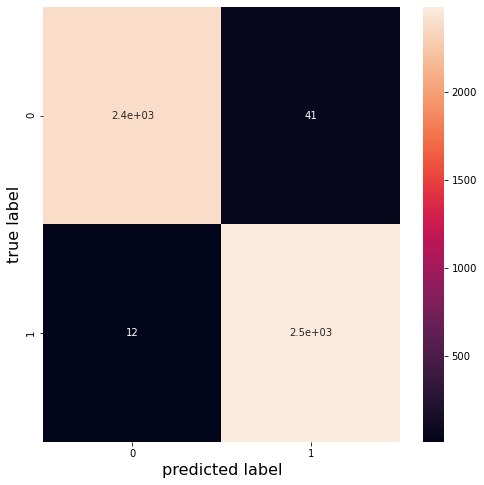

In [24]:
# Creating confusion matrix of true and predicted values
plt.figure(figsize = (8, 8))
ypreds = (ypreds > 0.5)
cm = confusion_matrix(y_validation, ypreds)
sns.heatmap(cm, annot=True)
plt.xlabel("predicted label", fontsize=16)
plt.ylabel("true label", fontsize=16);

In [25]:
# Evaluating the ranking model performance metric
print (classification_report(y_validation, ypreds))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2435
           1       0.98      1.00      0.99      2493

    accuracy                           0.99      4928
   macro avg       0.99      0.99      0.99      4928
weighted avg       0.99      0.99      0.99      4928



## The RandomForestClassifier model ranks both classes very well.

In [26]:
## The ROC-AUC metric tells us how reliable our forecasting model is.
print(f"ROC-AUC score: {roc_auc_score(y_validation.values, ypreds)}")

ROC-AUC score: 0.839942310749359
